# Nested ANOVA - one between factor
Reference: http://www.flutterbys.com.au/stats/tut/tut9.2b.html

In [1]:
import pandas as pd
import numpy as np
 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pymc3 as pm
import patsy

C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Data loading

In [2]:
#curdies = pd.read_csv('../datasets/curdies.csv', na_values=0)
curdies = pd.read_csv('../datasets/curdies.csv')
curdies.head()

,SEASON,SITE,DUGESIA,S4DUGES
0,WINTER,1,0.647683,0.897100
1,WINTER,1,6.096152,1.571317
2,WINTER,1,1.310564,1.069953
3,WINTER,1,1.725279,1.146080
4,WINTER,1,1.459387,1.099114


In [3]:
labels_SITE = ['{}{}'.format(curdies['SITE'][i], curdies['SEASON'][j][0]) for i, j in zip(curdies['SITE'].index, curdies['SEASON'].index)]
labels_SITE = sorted(list(set(labels_SITE)))
labels_SITE

['1W', '2W', '3W', '4S', '5S', '6S']

In [4]:
#curdies.dropna(axis=0, inplace=True)
#curdies.reset_index(inplace=True)
curdies.head()

,SEASON,SITE,DUGESIA,S4DUGES
0,WINTER,1,0.647683,0.897100
1,WINTER,1,6.096152,1.571317
2,WINTER,1,1.310564,1.069953
3,WINTER,1,1.725279,1.146080
4,WINTER,1,1.459387,1.099114


In [5]:
curdies['SEASON'] = pd.Categorical(curdies['SEASON'].apply(lambda x: x.strip()), categories=['WINTER', 'SUMMER'], ordered=True)
curdies['SITE'] = pd.Categorical(curdies['SITE'], ordered=False)
curdies['SITE'].cat.rename_categories(labels_SITE, inplace=True)
curdies.head(10)

,SEASON,SITE,DUGESIA,S4DUGES
0,WINTER,1W,0.647683,0.897100
1,WINTER,1W,6.096152,1.571317
2,WINTER,1W,1.310564,1.069953
3,WINTER,1W,1.725279,1.146080
4,WINTER,1W,1.459387,1.099114
5,WINTER,1W,1.057561,1.014090
6,WINTER,2W,1.016298,1.004050
7,WINTER,2W,16.196794,2.006122
8,WINTER,2W,1.168081,1.039605
9,WINTER,2W,1.024299,1.006020


In [6]:
curdies_agg = curdies.groupby(by=['SEASON', 'SITE'], as_index=False).mean()
curdies_agg.dropna(axis=0, inplace=True)
curdies_agg.reset_index(inplace=True)
curdies_agg

,index,SEASON,SITE,DUGESIA,S4DUGES
0,0,WINTER,1W,2.049437,1.132942
1,1,WINTER,2W,4.181908,1.271870
2,2,WINTER,3W,0.678206,0.867871
3,9,SUMMER,4S,0.419095,0.350821
4,10,SUMMER,5S,0.229086,0.180462
5,11,SUMMER,6S,0.194244,0.381122


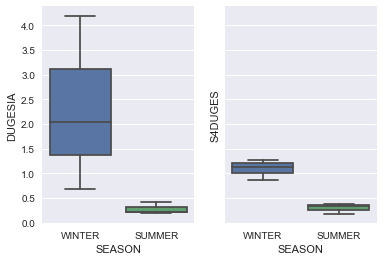

In [7]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)

sns.boxplot(data=curdies_agg, x='SEASON', y='DUGESIA', ax=ax[0]) # variance is non heterogeneous
sns.boxplot(data=curdies_agg, x='SEASON', y='S4DUGES', ax=ax[1]) # the 4th root transformation helps at making the variance heterogeneous

## Fit hierarchical model
I will use the matrix parametrization

In [8]:
#X = patsy.dmatrix('SEASON', data=curdies_agg, return_type='dataframe')
#X # the size should be (n_sites, n_seasons), that is the number of row should be equal to the number of random factors
X = patsy.dmatrix("SEASON", data=curdies, return_type='dataframe')
X = np.asarray(X)
X

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.]])

In [9]:
# Random effect on the intercepts
Z = patsy.dmatrix('-1 + SITE', data=curdies, return_type='dataframe')
Z = np.asarray(Z)

In [10]:
Y = np.asarray(curdies.S4DUGES)
Y

array([0.8970995, 1.5713175, 1.0699526, 1.1460797, 1.0991136, 1.0140897,
       1.0040498, 2.0061216, 1.0396048, 1.0060202, 1.1908882, 1.3845343,
       0.9111253, 1.0507807, 1.0271582, 0.9002881, 0.6074385, 0.7104333,
       0.       , 0.       , 0.9849349, 0.       , 0.       , 1.1199931,
       1.0827734, 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.6037669, 0.       , 0.9006648, 0.7823021])

In [11]:
with pm.Model() as model:
    
    ## Priors
    # SEASON (2 levels)
    # The values split on season have the same variance (see boxplot above)
    
    # Coefficients for WINTER and SUMMER
    beta_X = pm.Normal('beta_X', mu=0, sd=50, shape=X.shape[1])
    
    estimate_X = pm.math.dot(X, beta_X)
     
    # SITE (6 levels)
    # There are 6 different sites, 3 within SEASON
    sigma_Z = pm.HalfCauchy('sigma_Z', beta=3)
    
    # Centered version
    gamma_Z = pm.Normal('gamma_Z', mu=0, sd=sigma_Z, shape=Z.shape[1])
    
    # Non Centered version
    #gamma_Z_offset = pm.Normal('gamma_Z_offset', mu=0, sd=1, shape=Z.shape[1])
    #gamma_Z = pm.Deterministic('gamma_Z', gamma_Z_offset * sigma_Z)
    
    estimate_Z = pm.math.dot(Z, gamma_Z)
    
    ## likelihood
    estimate = estimate_X + estimate_Z
    sigma = pm.HalfCauchy('sigma', beta=3) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=estimate, sd=sigma, observed=Y)
    
    trace = pm.sample(draws=5000, chains=2, step=pm.NUTS(), njobs=2, tune=1500)

C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, gamma_Z, sigma_Z_log__, beta_X]
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


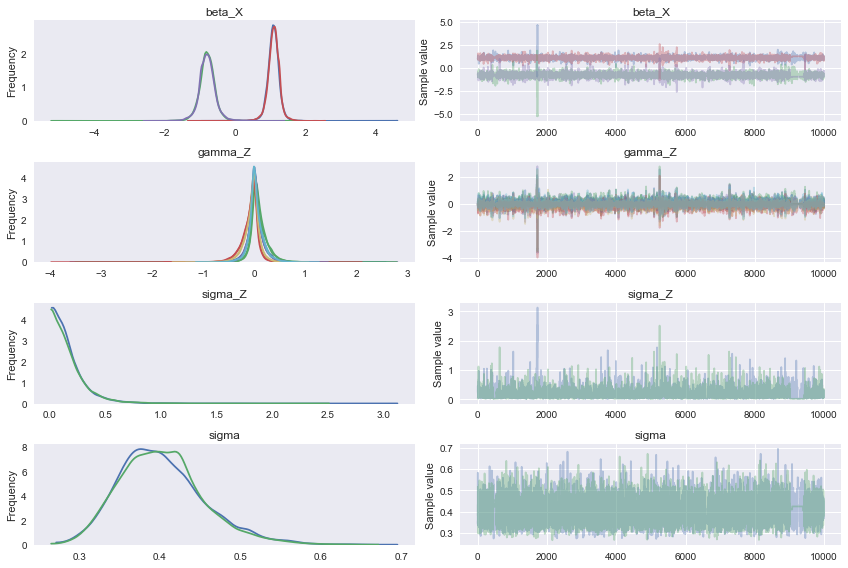

In [12]:
_ = pm.traceplot(trace)

In [13]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_X__0,1.091046,0.181248,0.002858,0.771107,1.421014,5987.0,1.000041
beta_X__1,-0.792146,0.251209,0.003713,-1.268997,-0.340504,5982.0,0.999998
gamma_Z__0,0.020917,0.179648,0.001641,-0.316683,0.367417,7066.0,1.000055
gamma_Z__1,0.080638,0.184736,0.002103,-0.216557,0.462300,6382.0,0.999961
gamma_Z__2,-0.093072,0.184395,0.002640,-0.500147,0.176923,6523.0,1.000025
gamma_Z__3,0.022589,0.161835,0.001987,-0.293770,0.367234,7673.0,0.999966
gamma_Z__4,-0.050646,0.165976,0.002005,-0.399756,0.264661,7729.0,0.999951
gamma_Z__5,0.034954,0.162574,0.002160,-0.267453,0.398262,7423.0,1.000153
sigma_Z,0.179370,0.167675,0.004570,0.014614,0.475068,1556.0,0.999950
sigma,0.402759,0.052911,0.000735,0.306097,0.509745,6997.0,0.999950


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F2F1CFCA90>,
      dtype=object)

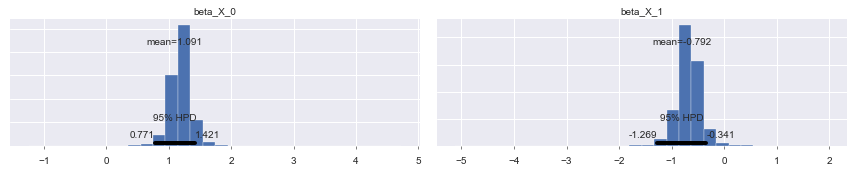

In [14]:
pm.plot_posterior(trace, varnames=['beta_X'])

The `beta_X` seems to be close enough

In [15]:
curdies.groupby(['SEASON'])[['S4DUGES']].mean()

,S4DUGES
SEASON,
WINTER,1.090894
SUMMER,0.304135


The `sigma` seems to be ok

In [16]:
curdies.groupby(['SEASON'])['S4DUGES'].std().mean()

0.3847746117705029

In [17]:
mcmc_X = trace['beta_X']

In [18]:
fit_X = np.dot(np.asarray(mcmc_X), X.T)

In [19]:
fit_X.mean(axis=0)

array([1.09104587, 1.09104587, 1.09104587, 1.09104587, 1.09104587,
       1.09104587, 1.09104587, 1.09104587, 1.09104587, 1.09104587,
       1.09104587, 1.09104587, 1.09104587, 1.09104587, 1.09104587,
       1.09104587, 1.09104587, 1.09104587, 0.29889941, 0.29889941,
       0.29889941, 0.29889941, 0.29889941, 0.29889941, 0.29889941,
       0.29889941, 0.29889941, 0.29889941, 0.29889941, 0.29889941,
       0.29889941, 0.29889941, 0.29889941, 0.29889941, 0.29889941,
       0.29889941])

In [20]:
mcmc_Z = trace['gamma_Z']

In [21]:
fit_Z = np.dot(np.asarray(mcmc_Z), Z.T)

In [22]:
fit_Z.mean(axis=0)

array([ 0.02091674,  0.02091674,  0.02091674,  0.02091674,  0.02091674,
        0.02091674,  0.08063762,  0.08063762,  0.08063762,  0.08063762,
        0.08063762,  0.08063762, -0.09307208, -0.09307208, -0.09307208,
       -0.09307208, -0.09307208, -0.09307208,  0.02258902,  0.02258902,
        0.02258902,  0.02258902,  0.02258902,  0.02258902, -0.05064567,
       -0.05064567, -0.05064567, -0.05064567, -0.05064567, -0.05064567,
        0.03495355,  0.03495355,  0.03495355,  0.03495355,  0.03495355,
        0.03495355])

In [23]:
fit = fit_X + fit_Z

In [24]:
curdies['S4DUGES_FIT'] = fit.mean(axis=0)

In [25]:
curdies

,SEASON,SITE,DUGESIA,S4DUGES,S4DUGES_FIT
0,WINTER,1W,0.647683,0.897100,1.111963
1,WINTER,1W,6.096152,1.571317,1.111963
2,WINTER,1W,1.310564,1.069953,1.111963
3,WINTER,1W,1.725279,1.146080,1.111963
4,WINTER,1W,1.459387,1.099114,1.111963
5,WINTER,1W,1.057561,1.014090,1.111963
6,WINTER,2W,1.016298,1.004050,1.171683
7,WINTER,2W,16.196794,2.006122,1.171683
8,WINTER,2W,1.168081,1.039605,1.171683
9,WINTER,2W,1.024299,1.006020,1.171683


## Alternative parametrization (hierarchical)

In [26]:
X = patsy.dmatrix('SEASON', data=curdies_agg, return_type='dataframe')
X = np.asarray(X)
X # the size should be (n_sites, n_seasons), that is the number of row should be equal to the number of random factors

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 1.],
       [1., 1.],
       [1., 1.]])

In [27]:
with pm.Model() as model:
    
    ## Priors
    # SEASON (2 levels)
    # The values split on season have the same variance (see boxplot above)
    
    # Coefficients for WINTER and SUMMER
    beta_X = pm.Normal('beta_X', mu=0, sd=50, shape=X.shape[1])
    
    estimate_X = pm.math.dot(X, beta_X)
     
    # SITE (6 levels)
    # There are 6 different sites, 3 within SEASON
    sigma_Z = pm.HalfCauchy('sigma_Z', beta=3)
    
    # Centered version
    gamma_Z = pm.Normal('gamma_Z', mu=estimate_X, sd=sigma_Z, shape=Z.shape[1])
    
    # Non Centered version
    #gamma_Z_offset = pm.Normal('gamma_Z_offset', mu=0, sd=1, shape=Z.shape[1])
    #gamma_Z = pm.Deterministic('gamma_Z', gamma_Z_offset * sigma_Z)
    
    estimate_Z = pm.math.dot(Z, gamma_Z)
    
    ## likelihood
    estimate = estimate_Z
    sigma = pm.HalfCauchy('sigma', beta=3) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=estimate, sd=sigma, observed=Y)
    
    trace = pm.sample(draws=5000, chains=2, step=pm.NUTS(), njobs=2, tune=1500)

C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, gamma_Z, sigma_Z_log__, beta_X]
There were 1424 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6405086294394966, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1543 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6033167965460976, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


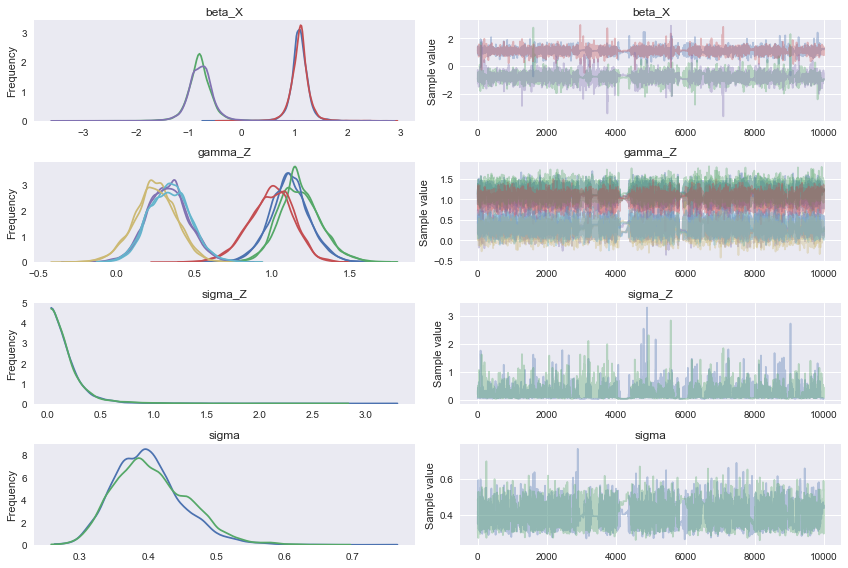

In [28]:
_ = pm.traceplot(trace)

In [29]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_X__0,1.093949,0.180519,0.003161,0.737206,1.418372,3798.0,1.000278
beta_X__1,-0.785693,0.263033,0.005075,-1.256146,-0.289897,4069.0,0.999966
gamma_Z__0,1.112769,0.129305,0.002256,0.846168,1.366132,3455.0,1.000076
gamma_Z__1,1.178718,0.136304,0.003144,0.914360,1.455110,1646.0,1.000692
gamma_Z__2,0.988818,0.143064,0.003820,0.694355,1.248087,753.0,1.000649
gamma_Z__3,0.327257,0.133547,0.003003,0.060857,0.583025,1300.0,1.000032
gamma_Z__4,0.248141,0.136639,0.003681,-0.020717,0.517925,819.0,0.999974
gamma_Z__5,0.340198,0.133512,0.003154,0.089564,0.608388,1295.0,0.999950
sigma_Z,0.197808,0.186777,0.005759,0.032646,0.510440,670.0,1.000054
sigma,0.402491,0.052475,0.001668,0.305124,0.501740,719.0,1.002369


## Re-fit after removing missing values from dataset

In [30]:
curdies = pd.read_csv('../datasets/curdies.csv', na_values=0)
curdies.head()

,SEASON,SITE,DUGESIA,S4DUGES
0,WINTER,1,0.647683,0.897100
1,WINTER,1,6.096152,1.571317
2,WINTER,1,1.310564,1.069953
3,WINTER,1,1.725279,1.146080
4,WINTER,1,1.459387,1.099114


In [31]:
curdies.dropna(axis=0, inplace=True)
curdies.reset_index(inplace=True)
curdies.head()

,index,SEASON,SITE,DUGESIA,S4DUGES
0,0,WINTER,1,0.647683,0.897100
1,1,WINTER,1,6.096152,1.571317
2,2,WINTER,1,1.310564,1.069953
3,3,WINTER,1,1.725279,1.146080
4,4,WINTER,1,1.459387,1.099114


In [32]:
curdies['SEASON'] = pd.Categorical(curdies['SEASON'].apply(lambda x: x.strip()), categories=['WINTER', 'SUMMER'], ordered=True)
curdies['SITE'] = pd.Categorical(curdies['SITE'], ordered=False)
curdies['SITE'].cat.rename_categories(labels_SITE, inplace=True)
curdies

,index,SEASON,SITE,DUGESIA,S4DUGES
0,0,WINTER,1W,0.647683,0.897100
1,1,WINTER,1W,6.096152,1.571317
2,2,WINTER,1W,1.310564,1.069953
3,3,WINTER,1W,1.725279,1.146080
4,4,WINTER,1W,1.459387,1.099114
5,5,WINTER,1W,1.057561,1.014090
6,6,WINTER,2W,1.016298,1.004050
7,7,WINTER,2W,16.196794,2.006122
8,8,WINTER,2W,1.168081,1.039605
9,9,WINTER,2W,1.024299,1.006020


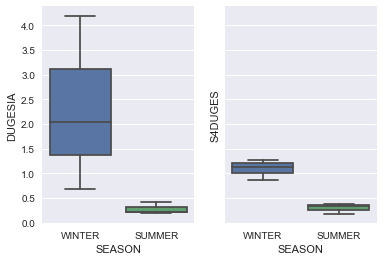

In [33]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)

sns.boxplot(data=curdies_agg, x='SEASON', y='DUGESIA', ax=ax[0]) # variance is non heterogeneous
sns.boxplot(data=curdies_agg, x='SEASON', y='S4DUGES', ax=ax[1]) # the 4th root transformation helps at making the variance heterogeneous

In [34]:
X = patsy.dmatrix("SEASON", data=curdies, return_type='dataframe')
X = np.asarray(X)
X

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.]])

In [35]:
# Random effect on the intercepts
Z = patsy.dmatrix('-1 + SITE', data=curdies, return_type='dataframe')
Z = np.asarray(Z)
Z

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]])

In [36]:
Y = np.asarray(curdies.S4DUGES)
Y

array([0.8970995, 1.5713175, 1.0699526, 1.1460797, 1.0991136, 1.0140897,
       1.0040498, 2.0061216, 1.0396048, 1.0060202, 1.1908882, 1.3845343,
       0.9111253, 1.0507807, 1.0271582, 0.9002881, 0.6074385, 0.7104333,
       0.9849349, 1.1199931, 1.0827734, 0.6037669, 0.9006648, 0.7823021])

In [37]:
with pm.Model() as model:
    
    ## Priors
    # SEASON (2 levels)
    # The values split on season have the same variance (see boxplot above)
    sigma_X = pm.HalfCauchy('sigma_X', beta=3)
    # Coefficients for WINTER and SUMMER
    beta_X = pm.Normal('beta_X', mu=0, sd=sigma_X, shape=X.shape[1])
    
    estimate_X = pm.math.dot(X, beta_X)
     
    # SITE (6 levels)
    # There are 6 different sites, 3 within SEASON
    sigma_Z = pm.HalfCauchy('sigma_Z', beta=3)
    
    # Centered version
    gamma_Z = pm.Normal('gamma_Z', mu=0, sd=sigma_Z, shape=Z.shape[1])
    
    # Non Centered version
    #gamma_Z_offset = pm.Normal('gamma_Z_offset', mu=0, sd=1, shape=Z.shape[1])
    #gamma_Z = pm.Deterministic('gamma_Z', gamma_Z_offset * sigma_Z)
    
    estimate_Z = pm.math.dot(Z, gamma_Z)
    
    ## likelihood
    estimate = estimate_X + estimate_Z
    sigma = pm.HalfCauchy('sigma', beta=5) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=estimate, sd=sigma, observed=Y)
    
    trace = pm.sample(draws=5000, chains=4, step=pm.NUTS(), njobs=2, tune=1500)

C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma_log__, gamma_Z, sigma_Z_log__, beta_X, sigma_X_log__]
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


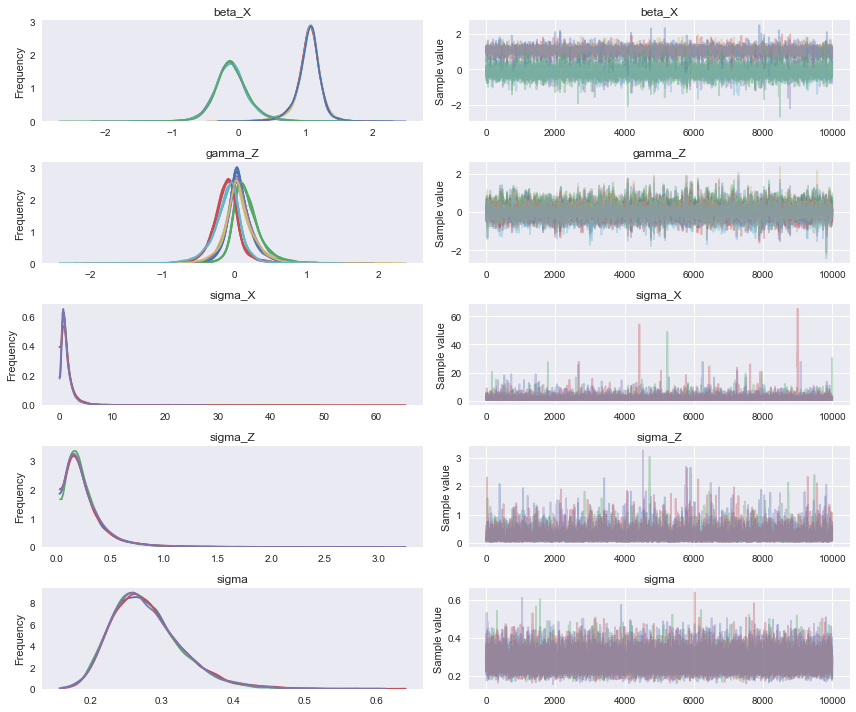

In [38]:
_ = pm.traceplot(trace)

In [39]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_X__0,1.045439,0.194804,0.002163,0.621962,1.415657,8668.0,1.000070
beta_X__1,-0.109931,0.273902,0.002355,-0.633398,0.458822,13219.0,1.000100
gamma_Z__0,0.069723,0.201649,0.002118,-0.299162,0.517051,9238.0,1.000022
gamma_Z__1,0.168205,0.210161,0.002241,-0.187620,0.633894,8521.0,0.999962
gamma_Z__2,-0.117696,0.198394,0.002083,-0.534976,0.270302,10148.0,1.000229
gamma_Z__3,0.060589,0.214902,0.001580,-0.363186,0.497708,16568.0,1.000076
gamma_Z__4,0.059067,0.228410,0.001614,-0.389416,0.539977,18310.0,1.000249
gamma_Z__5,-0.103057,0.215681,0.001868,-0.560728,0.300251,17020.0,1.000178
sigma_X,1.584438,1.628427,0.021172,0.222989,4.048396,7290.0,1.000543
sigma_Z,0.257079,0.198509,0.002439,0.022850,0.617164,6144.0,1.000031
